In [2]:
# general tools
import sys
from glob import glob
from datetime import datetime, timedelta

# data tools
import h5py
import netCDF4 as nc
import numpy as np

# stats tools
from skgstat import Variogram
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter
from scipy.stats import pearsonr, spearmanr

# graph tools
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.colors as colors
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection

from matplotlib import ticker
import matplotlib.ticker as mticker
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# custom tools
sys.path.insert(0, '/glade/u/home/ksha/WORKSPACE/utils/')
sys.path.insert(0, '/glade/u/home/ksha/WORKSPACE/DL_downscaling/utils/')
sys.path.insert(0, '/glade/u/home/ksha/WORKSPACE/DL_downscaling/')
from namelist import *
import data_utils as du
import graph_utils as gu
import verif_utils as vu
import model_utils as mu
import train_utils as tu

In [3]:
import importlib
importlib.reload(vu)

<module 'verif_utils' from '/glade/u/home/ksha/WORKSPACE/DL_downscaling/utils/verif_utils.py'>

In [4]:
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

# Global settings

### Filepath & filename

In [5]:
DATA_dir = PRISM_dir
RESULT_dir = save_dir
era_feature_path = ERA_dir + 'ERA_TMEAN_features_2015_2020.hdf'
jra_feature_path = JRA_dir + 'JRA_TMEAN_features_2015_2020.hdf'
prism_path = PRISM_dir+'PRISM_regrid_2015_2020.hdf'
# result files
era_pred_name = 'ERA_TMEAN_clean'
jra_pred_name = 'JRA_TMEAN_clean'

In [6]:
TMEAN_key = 'TMEAN_025'
ERA_025_key = 'era_025'
ERA_raw_key = 'era_raw'
JRA_025_key = 'jra_025'
JRA_raw_key = 'jra_raw'

### Domain and time

In [34]:
with h5py.File(PRISM_dir+'land_mask_NA.hdf', 'r') as hdf_io:
    lon_clean = hdf_io['lon_025'][...]
    lat_clean = hdf_io['lat_025'][...]
    land_mask = hdf_io['land_mask'][...]
    land_mask_clean = hdf_io['land_mask_025'][...]

In [8]:
ind_lat_US = [0, 100]
ind_lon_US = [60, 159]

In [9]:
with nc.Dataset(BACKUP_dir+'ETOPO1_Ice_g_gmt4.grd') as nc_obj:
    etopo_x = nc_obj.variables['x'][2000:] # subsetting north america
    etopo_y = nc_obj.variables['y'][6000:]
    etopo_z = nc_obj.variables['z'][6000:, 2000:]
etopo_lon, etopo_lat = np.meshgrid(etopo_x, etopo_y)

etopo_clean = du.interp2d_wraper(etopo_lon, etopo_lat, etopo_z, lon_clean, lat_clean, method=interp_method)

In [10]:
etopo_clean[etopo_clean<0] = 0
etopo_clean[land_mask_clean] = np.nan

### Time 

In [11]:
# available time range of the file (2018-2019) <----- support 2020 test in the furture 
N_all = 365 + 366 + 365 + 365 + 365
all_list = [datetime(2015, 1, 1, 0) + timedelta(days=x) for x in range(N_all)]
# time range for plotting (2018-2019)
N_pred_era = 365 + 243
pred_list_era = [datetime(2018, 1, 1, 0) + timedelta(days=x) for x in range(N_pred_era)]
N_pred_jra = 365 + 365
pred_list_jra = [datetime(2018, 1, 1, 0) + timedelta(days=x) for x in range(N_pred_jra)]
# indices
ind_era = du.dt_match(all_list, pred_list_era)
ind_jra = du.dt_match(all_list, pred_list_jra)

In [12]:
fake_x = np.arange(N_pred_jra)

### Graph param.

In [13]:
# Cartopy map settings
scale_param = '50m' # 10m for publication quality
# US states and CAN-US boundary
PROVINCE = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale=scale_param,
    facecolor='none')

In [14]:
cmap_mae = plt.cm.plasma_r # MAE colormap
cmap_line = plt.cm.plasma_r # line color "base"

camp_t2 = gu.cmap_combine(plt.cm.viridis, plt.cm.plasma_r)

line_colors = [cmap_line(45), cmap_line(90), cmap_line(135), cmap_line(180), cmap_line(225)]

rgb_array = camp_t2(range(256))
vmap = colors.ListedColormap(rgb_array[::25], name='temp')

C1 = plt.cm.plasma(96)
C2 = plt.cm.plasma(225)
C3 = plt.cm.viridis(180)

In [15]:
len(rgb_array[40::20])

11

In [16]:
fig_keys = {'dpi':250, 
            'orientation':'portrait', 
            'papertype':'a4',
            'bbox_inches':'tight', 
            'pad_inches':0.05, 
            'transparent':False}

## Import data

In [37]:
with h5py.File(save_dir+'ERA_PRED_TMEAN_2018_2020.hdf', 'r') as hdf_io:
    ERA_4km = hdf_io['RESULT_UNET'][...]
with h5py.File(save_dir+'JRA_PRED_TMEAN_2018_2020.hdf', 'r') as hdf_io:
    JRA_4km = hdf_io['RESULT_UNET'][...]
ERA_4km[:, land_mask] = np.nan
JRA_4km[:, land_mask] = np.nan

### Clean 0.25 degree

In [17]:
with h5py.File(ERA_dir+era_pred_name+'_2018.hdf', 'r') as hdf_io:
    ERA_2018 = hdf_io[TMEAN_key][...]
with h5py.File(ERA_dir+era_pred_name+'_2019.hdf', 'r') as hdf_io:
    ERA_2019 = hdf_io[TMEAN_key][...]
    
with h5py.File(JRA_dir+jra_pred_name+'_2018.hdf', 'r') as hdf_io:
    JRA_2018 = hdf_io[TMEAN_key][...]
with h5py.File(JRA_dir+jra_pred_name+'_2019.hdf', 'r') as hdf_io:
    JRA_2019 = hdf_io[TMEAN_key][...]
    
ERA_clean = np.concatenate((ERA_2018, ERA_2019), axis=0)
JRA_clean = np.concatenate((JRA_2018, JRA_2019), axis=0)

ERA_clean[:, land_mask_clean] = np.nan
JRA_clean[:, land_mask_clean] = np.nan

### PRISM (US) 0.25 degree

In [18]:
with h5py.File(prism_path, 'r') as hdf_io:
    PRISM_clean = hdf_io[TMEAN_key][...]
    lon_prism = hdf_io['lon_025'][...]
    lat_prism = hdf_io['lat_025'][...]
PRISM_clean[:, land_mask_clean[ind_lat_US[0]:ind_lat_US[1], ind_lon_US[0]:ind_lon_US[1]]] = np.nan

In [19]:
with h5py.File(era_feature_path, 'r') as hdf_io:
    ERA_025 = hdf_io[ERA_025_key][ind_era, ...]
with h5py.File(jra_feature_path, 'r') as hdf_io:
    JRA_025 = hdf_io[JRA_025_key][ind_jra, ...]
ERA_025[:, land_mask_clean] = np.nan
JRA_025[:, land_mask_clean] = np.nan

### Raw reanalysis

In [20]:
with h5py.File(era_feature_path, 'r') as hdf_io:
    ERA_raw = hdf_io[ERA_raw_key][ind_era, ...]
    lon_ERA = hdf_io['lon_raw'][...]
    lat_ERA = hdf_io['lat_raw'][...]

with h5py.File(jra_feature_path, 'r') as hdf_io:
    JRA_raw = hdf_io[JRA_raw_key][ind_jra, ...]
    lon_JRA = hdf_io['lon_raw'][...]
    lat_JRA = hdf_io['lat_raw'][...]

In [21]:
# # land mask interp
# flag_mask = griddata((lon_clean.ravel(), lat_clean.ravel()), land_mask_clean.ravel(), (lon_ERA, lat_ERA), method='linear')
# land_mask_ERA = flag_mask > 0
# land_mask_ERA[:, :14] = True
# land_mask_ERA[:, 71:] = True

# flag_mask = griddata((lon_clean.ravel(), lat_clean.ravel()), land_mask_clean.ravel(), (lon_JRA, lat_JRA), method='linear')
# land_mask_JRA = flag_mask > 0
# land_mask_JRA[:, :18] = True
# land_mask_JRA[:, 89:] = True

with h5py.File(save_dir+'CGAN_ERA_Variogram.hdf', 'r') as hdf_io:
    land_mask_ERA = hdf_io['land_mask'][...]
with h5py.File(save_dir+'CGAN_JRA_Variogram.hdf', 'r') as hdf_io:
    land_mask_JRA = hdf_io['land_mask'][...]

In [22]:
ERA_raw[:, land_mask_ERA] = np.nan
JRA_raw[:, land_mask_JRA] = np.nan

### Clean 0.25 degree interpolated to raw reanalysis grids

In [23]:
# # ERA interp
# grid_shape = lon_ERA.shape
# ERA_clean_raw = np.empty((N_pred_era,)+grid_shape)
# for i in range(N_pred_era):
#     ERA_clean_raw[i, ...] = du.interp2d_wraper(lon_clean, lat_clean, ERA_clean[i, ...], lon_ERA, lat_ERA, method=interp_method)
# ERA_clean_raw[:, land_mask_ERA] = np.nan

In [24]:
# # JRA interp
# grid_shape = lon_JRA.shape
# JRA_clean_raw = np.empty((N_pred_era,)+grid_shape)
# for i in range(N_pred_era):
#     JRA_clean_raw[i, ...] = du.interp2d_wraper(lon_clean, lat_clean, JRA_clean[i, ...], lon_JRA, lat_JRA, method=interp_method)
# JRA_clean_raw[:, land_mask_JRA] = np.nan

## Mean & std

In [24]:
np.nanstd(JRA_clean)

11.089658040696131

In [25]:
JRA_clim = np.zeros([4, N_pred_jra])*np.nan
JRA_clim[0, :] = np.nanmean(JRA_raw, axis=(1, 2))
JRA_clim[1, :] = np.nanmean(JRA_clean, axis=(1, 2))
JRA_clim[2, :] = np.nanstd(JRA_raw, axis=(1, 2))
JRA_clim[3, :] = np.nanstd(JRA_clean, axis=(1, 2))

ERA_clim = np.zeros([4, N_pred_jra])*np.nan
ERA_clim[0, :N_pred_era] = np.nanmean(ERA_raw, axis=(1, 2))
ERA_clim[1, :N_pred_era] = np.nanmean(ERA_clean, axis=(1, 2))
ERA_clim[2, :N_pred_era] = np.nanstd(ERA_raw, axis=(1, 2))
ERA_clim[3, :N_pred_era] = np.nanstd(ERA_clean, axis=(1, 2))

In [26]:
JRA_raw_smean = np.nanmean(JRA_raw[:365, ...], axis=0)
JRA_clean_smean = np.nanmean(JRA_clean[:365, ...], axis=0)
ERA_raw_smean = np.nanmean(ERA_raw[:365, ...], axis=0)
ERA_clean_smean = np.nanmean(ERA_clean[:365, ...], axis=0)

In [27]:
JRA_raw0 = np.nanmean(JRA_raw[:365, ...])
JRA_clean0 = np.nanmean(JRA_clean[:365, ...])
ERA_raw0 = np.nanmean(ERA_raw[:365, ...])
ERA_clean0 = np.nanmean(ERA_clean[:365, ...])

In [28]:
def setBoxColors(bp, c, lw, horizontal=False):
    plt.setp(bp['boxes'][0], color=c, linewidth=lw)
    plt.setp(bp['caps'][0], color=c, linewidth=lw)
    plt.setp(bp['caps'][1], color=c, linewidth=lw)
    plt.setp(bp['whiskers'][0], color=c, linewidth=lw)
    plt.setp(bp['whiskers'][1], color=c, linewidth=lw)
    plt.setp(bp['medians'][0], color=c, linewidth=lw)
    
    outliers = bp['fliers'][0]
    data = outliers.get_data()
    if horizontal:
        if len(data[0]) > 2:
            # horizontal boxplot only <--- !!!
            xmid_val = bp['medians'][0].get_xdata()[0]
            xminmax = np.array([np.min(data[0]), np.max(data[0])])
            yminmax = np.array([np.min(data[1]), np.max(data[1])])

            if xminmax[0] < xmid_val and xminmax[1] > xmid_val:
                data_new = (xminmax, yminmax)
            elif xminmax[1] <= xmid_val:
                data_new = (xminmax[0], yminmax[0])
            elif xminmax[0] >= xmid_val:
                data_new = (xminmax[1], yminmax[1])
            outliers.set_data(data_new)
    else:
        if len(data[0]) > 2:
            # horizontal boxplot only <--- !!!
            ymid_val = bp['medians'][0].get_ydata()[0]
            xminmax = np.array([np.min(data[0]), np.max(data[0])])
            yminmax = np.array([np.min(data[1]), np.max(data[1])])

            if yminmax[0] < ymid_val and yminmax[1] > ymid_val:
                data_new = (xminmax, yminmax)
            elif yminmax[1] <= ymid_val:
                data_new = (xminmax[0], yminmax[0])
            elif yminmax[0] >= ymid_val:
                data_new = (xminmax[1], yminmax[1])
            outliers.set_data(data_new)

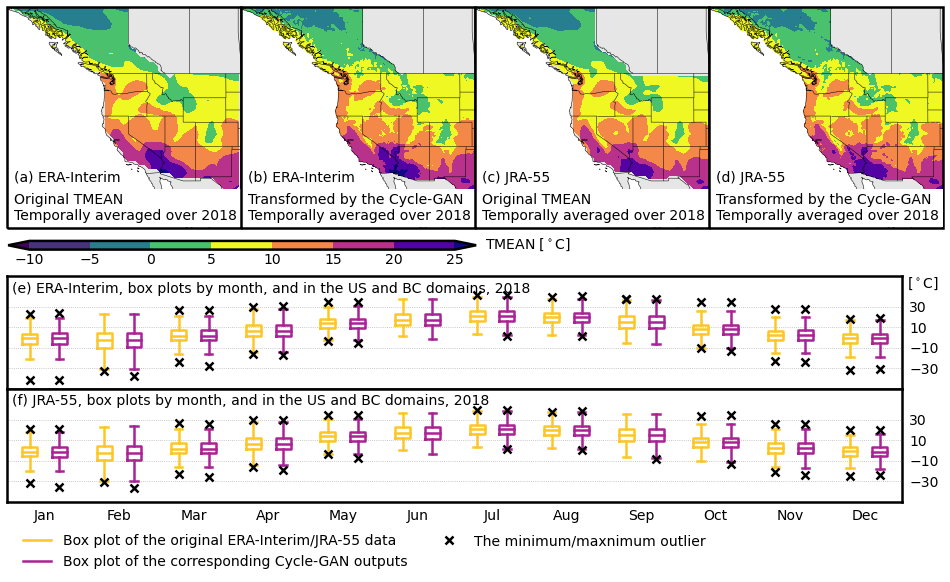

In [29]:
edge = [np.min(lon_clean[20:-8, 0:-6]), np.max(lon_clean[20:-8, 0:-6]), 23.5, 58.5]

fig = plt.figure(figsize=(13, 6.9))

gs = gridspec.GridSpec(4, 5, height_ratios=[1, 0.2, 0.5, 0.5], width_ratios=[1, 1, 1, 0.825, 0.175])
ax1 = plt.subplot(gs[0, 0], projection=ccrs.PlateCarree())
ax2 = plt.subplot(gs[0, 1], projection=ccrs.PlateCarree())
ax3 = plt.subplot(gs[0, 2], projection=ccrs.PlateCarree())
ax4 = plt.subplot(gs[0, 3:], projection=ccrs.PlateCarree())

ax_gap = plt.subplot(gs[1, :])

ax5 = plt.subplot(gs[2, :4])
ax6 = plt.subplot(gs[3, :4])

plt.subplots_adjust(0, 0, 1, 1, hspace=0, wspace=0)
ax_gap.set_axis_off()

AX_map = [ax1, ax2, ax3, ax4]
AX_box = [ax5, ax6]

titles = ['(a) ERA-Interim',
          '(b) ERA-Interim',
          '(c) JRA-55',
          '(d) JRA-55']

words = ['Original TMEAN\nTemporally averaged over 2018',
         'Transformed by the Cycle-GAN\nTemporally averaged over 2018',
         'Original TMEAN\nTemporally averaged over 2018',
         'Transformed by the Cycle-GAN\nTemporally averaged over 2018']

title_bars = ['(e) ERA-Interim, box plots by month, and in the US and BC domains, 2018', 
              '(f) JRA-55, box plots by month, and in the US and BC domains, 2018']

monname = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

title_locx = [0.03]*4
title_locy = [0.26]*4
for i, ax in enumerate(AX_map):
    ax.set_extent(edge, ccrs.Geodetic())
    ax.add_feature(cfeature.LAND.with_scale(scale_param), facecolor='0.9')
    ax.add_feature(cfeature.COASTLINE.with_scale(scale_param), edgecolor='k', linewidth=0.5)
    ax.add_feature(cfeature.BORDERS.with_scale(scale_param), linestyle='-', linewidth=0.5)
    ax.add_feature(PROVINCE, edgecolor='k', linestyle='-', linewidth=0.5)
    ax.outline_patch.set_linewidth(2.5)
    handle_box = ax.text(title_locx[i], title_locy[i], titles[i], fontsize=14, ha='left', va='top', transform=ax.transAxes)
    handle_box.set_bbox(dict(facecolor='none', alpha=1, edgecolor='none'))
    
    handle_box = ax.text(title_locx[i], title_locy[i]-0.1, words[i], fontsize=14, ha='left', va='top', transform=ax.transAxes)
    handle_box.set_bbox(dict(facecolor='w', alpha=1, edgecolor='none'))

ax_gap.text(0.51, 0.5, 'TMEAN [$\mathsf{^\circ C}$]', fontsize=14, ha='left', va='bottom', transform=ax_gap.transAxes)
    
for i, ax in enumerate(AX_box):
    ax = gu.ax_decorate_box(ax)
    ax.grid(linestyle=':'); ax.xaxis.grid(False)
    ax.set_xlim([-0.5, 11.5])
    ax.set_ylim([-50, 60])
    ax.set_yticks([-30, -10, 10, 30])
    ax.tick_params(labelright=True)
    handle_box = ax.text(0.005, 0.95, title_bars[i], fontsize=14, ha='left', va='top', transform=ax.transAxes)
    handle_box.set_bbox(dict(facecolor='none', alpha=1, edgecolor='none'))
    
AX_box[0].text(1.005, 1, '[$\mathsf{^\circ C}$]', ha='left', va='top', fontsize=14, transform=AX_box[0].transAxes)

tlim = [-10, 20]
levs = [-10, -5, 0, 5, 10, 15, 20, 25]
AX_map[0].contourf(lon_ERA[7:-2, 14:-9], lat_ERA[7:-2, 14:-9], ERA_raw_smean[7:-2, 14:-9], levs, cmap=camp_t2, extend='both')
AX_map[1].contourf(lon_clean[20:-8, 0:-6], lat_clean[20:-8, 0:-6], ERA_clean_smean[20:-8, 0:-6], levs, cmap=camp_t2, extend='both')
AX_map[2].contourf(lon_JRA[9:-3, 18:-12], lat_JRA[9:-3, 18:-12], JRA_raw_smean[9:-3, 18:-12], levs, cmap=camp_t2, extend='both')
CS = AX_map[3].contourf(lon_clean[20:-8, 0:-6], lat_clean[20:-8, 0:-6], JRA_clean_smean[20:-8, 0:-6], levs, cmap=camp_t2, extend='both')


CBOX1 = C2
CBOX2 = C1

day_gap = 30
outliers1 = {'marker':'x', 'ms':8, 'mew':2.5, 'mec':'k'}
outliers2 = {'marker':'x', 'ms':8, 'mew':2.5, 'mec':'k'}

for i in range(12):
    pos1 = i-0.2
    pos2 = i+0.2
    
    temp_raw_era = ERA_raw[day_gap*i:day_gap*(i+1), ~land_mask_ERA].ravel()
    temp_clean_era = ERA_clean[day_gap*i:day_gap*(i+1), ~land_mask_clean].ravel()
    handle1 = AX_box[0].boxplot(temp_raw_era, positions=[pos1], widths=0.2, flierprops=outliers1)
    handle2 = AX_box[0].boxplot(temp_clean_era, positions=[pos2], widths=0.2, flierprops=outliers2)
    setBoxColors(handle1, CBOX1, 2.5)
    setBoxColors(handle2, CBOX2, 2.5)
    
    temp_raw_jra = JRA_raw[day_gap*i:day_gap*(i+1), ~land_mask_JRA].ravel()
    temp_clean_jra = JRA_clean[day_gap*i:day_gap*(i+1), ~land_mask_clean].ravel()
    handle1 = AX_box[1].boxplot(temp_raw_jra, positions=[pos1], widths=0.2, flierprops=outliers1)
    handle2 = AX_box[1].boxplot(temp_clean_jra, positions=[pos2], widths=0.2, flierprops=outliers2)
    setBoxColors(handle1, CBOX1, 2.5)
    setBoxColors(handle2, CBOX2, 2.5)
    
AX_box[1].tick_params(labelbottom=True)
AX_box[1].set_xticks(np.arange(12))
AX_box[1].set_xticklabels(monname)

    
ax_lg = fig.add_axes([0, -0.14, 0.76, 0.1])#[0.5625, -0.18, 0.435, 0.15]
ax_lg.set_axis_off()
LG = ax_lg.legend([handle1["boxes"][0], handle2["boxes"][0], handle1['fliers'][0]],
                  ['Box plot of the original ERA-Interim/JRA-55 data',
                   'Box plot of the corresponding Cycle-GAN outputs',
                   'The minimum/maxnimum outlier'],
                  bbox_to_anchor=(1, 1), ncol=2, prop={'size':14})

LG.get_frame().set_facecolor('white')
LG.get_frame().set_edgecolor('k')
LG.get_frame().set_linewidth(0)

# colormap
ax_base = fig.add_axes([0.001, 0.475, 0.5, 0.05])
[j.set_linewidth(0) for j in ax_base.spines.values()]
ax_base.tick_params(axis='both', left=False, top=False, right=False, bottom=False, \
                    labelleft=False, labeltop=False, labelright=False, labelbottom=False)
cax = inset_axes(ax_base, width='100%', height='35%', borderpad=0, loc=9)
CBar = plt.colorbar(CS, orientation='horizontal', cax=cax) 
CBar.ax.tick_params(axis='x', labelsize=14, direction='in', length=0)
CBar.outline.set_linewidth(2.5)

# Save figure
fig.savefig(fig_dir+'CGAN_clim.png', format='png', **fig_keys)

## EOF stuff

In [30]:
# from eofs.standard import Eof
# def norm_copy(data, mu, std):
#     out = np.copy(data)
#     return (out-mu[:, None, None])/std[:, None, None]

In [31]:
# ERA_raw_PCA = Eof(norm_copy(ERA_raw[:365, ...], ERA_clim[0, :365], ERA_clim[2, :365]))
# JRA_raw_PCA = Eof(norm_copy(JRA_raw[:365, ...], JRA_clim[0, :365], JRA_clim[2, :365]))
# ERA_clean_PCA = Eof(norm_copy(ERA_clean[:365, ...], ERA_clim[1, :365], ERA_clim[3, :365]))
# JRA_clean_PCA = Eof(norm_copy(JRA_clean[:365, ...], JRA_clim[1, :365], JRA_clim[3, :365]))

In [32]:
# ERA_raw_EOF = ERA_raw_PCA.eofs(neofs=4, eofscaling=2) #pcscaling=1
# ERA_clean_EOF = ERA_clean_PCA.eofs(neofs=4, eofscaling=2)
# JRA_raw_EOF = JRA_raw_PCA.eofs(neofs=4, eofscaling=2)
# JRA_clean_EOF = JRA_clean_PCA.eofs(neofs=4, eofscaling=2)

# ERA_raw_PC = ERA_raw_PCA.pcs(npcs=4)#pcscaling=1
# ERA_clean_PC = ERA_clean_PCA.pcs(npcs=4)
# JRA_raw_PC = JRA_raw_PCA.pcs(npcs=4)
# JRA_clean_PC = JRA_clean_PCA.pcs(npcs=4)

# ERA_raw_expvar = ERA_raw_PCA.varianceFraction(neigs=4)
# ERA_clean_expvar = ERA_clean_PCA.varianceFraction(neigs=4)

# JRA_raw_expvar = JRA_raw_PCA.varianceFraction(neigs=4)
# JRA_clean_expvar = JRA_clean_PCA.varianceFraction(neigs=4)

In [33]:
# r_era_0, _ = pearsonr(ERA_raw_PC[:, 0], ERA_clean_PC[:, 0])
# r_era_1, _ = pearsonr(ERA_raw_PC[:, 1], ERA_clean_PC[:, 1])
# r_jra_0, _ = pearsonr(JRA_raw_PC[:, 0], JRA_clean_PC[:, 0])
# r_jra_1, _ = pearsonr(JRA_raw_PC[:, 1], JRA_clean_PC[:, 1])

# r_era_0 = np.round(r_era_0, 4)
# r_era_1 = np.round(r_era_1, 4)
# r_jra_0 = np.round(r_jra_0, 4)
# r_jra_1 = np.round(r_jra_1, 4)

In [34]:
# ERA_raw_expvar = np.round(ERA_raw_expvar*100, 2)
# ERA_clean_expvar = np.round(ERA_clean_expvar*100, 2)
# JRA_raw_expvar = np.round(JRA_raw_expvar*100, 2)
# JRA_clean_expvar = np.round(JRA_clean_expvar*100, 2)

In [35]:
# edge = [np.min(lon_clean[20:-8, 0:-6]), np.max(lon_clean[20:-8, 0:-6]),
#         np.min(lat_clean[20:-8, 0:-6]), 58.5]

# fig = plt.figure(figsize=(13, 13.9))

# gs = gridspec.GridSpec(5, 4, height_ratios=[1, 1, 0.05, 1, 1], width_ratios=[1, 1, 0.05, 1])
# ax1 = plt.subplot(gs[0, 0], projection=ccrs.PlateCarree())
# ax2 = plt.subplot(gs[0, 1], projection=ccrs.PlateCarree())
# ax3 = plt.subplot(gs[:2, 3])
# ax4 = plt.subplot(gs[1, 0], projection=ccrs.PlateCarree())
# ax5 = plt.subplot(gs[1, 1], projection=ccrs.PlateCarree())

# ax6 = plt.subplot(gs[3, 0], projection=ccrs.PlateCarree())
# ax7 = plt.subplot(gs[3, 1], projection=ccrs.PlateCarree())
# ax8 = plt.subplot(gs[3:5, 3])
# ax9 = plt.subplot(gs[4, 0], projection=ccrs.PlateCarree())
# ax10 = plt.subplot(gs[4, 1], projection=ccrs.PlateCarree())

# ax_gap = plt.subplot(gs[:, 2])
# ax_mid = plt.subplot(gs[2, :])

# plt.subplots_adjust(0, 0, 1, 1, hspace=0, wspace=0)

# ax_mid.set_axis_off()
# ax_gap.set_axis_off()

# AX_eofs = [ax1, ax2, ax4, ax5, ax6, ax7, ax9, ax10]
# AX_box = [ax3, ax8]

# titles = ['(a) ERA-Interim\n\nOriginal data',
#           '(b) ERA-Interim\n\nTransformed by\nthe Cycle-GAN', 
#           '(c) ERA-Interim\n\nOriginal data',
#           '(d) ERA-Interim\n\nTransformed by\nthe Cycle-GAN',
#           '(f) JRA-55\n\nOriginal data',
#           '(g) JRA-55\n\nTransformed by\nthe Cycle-GAN', 
#           '(h) JRA-55\n\nOriginal data',
#           '(i) JRA-55\n\nTransformed by\nthe Cycle-GAN']

# title_bars = ['(e) ERA-Interim TMEAN, year 2018', '(j) JRA-55 TMEAN, year 2018']

# words = ['EOF mode I\nexpvar = {}%\nCorr. of PCs = {}'.format(ERA_raw_expvar[0], r_era_0),
#          'EOF mode I\nexpvar = {}%'.format(ERA_clean_expvar[0]),
#          'EOF mode II\nexpvar = {}%\nCorr. of PCs = {}'.format(ERA_raw_expvar[1], r_era_1),
#          'EOF mode II\nexpvar = {}%'.format(ERA_clean_expvar[1]),
#          'EOF mode I\nexpvar = {}%\nCorr. of PCs = {}'.format(JRA_raw_expvar[0], r_jra_0),
#          'EOF mode I\nexpvar = {}%'.format(JRA_clean_expvar[0]), 
#          'EOF mode II\nexpvar = {}%\nCorr. of PCs = {}'.format(JRA_raw_expvar[1], r_jra_1),
#          'EOF mode II\nexpvar = {}%'.format(JRA_clean_expvar[1])]
# monname = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# title_locx = [0.03]*8
# title_locy = [0.6]*8
# for i, ax in enumerate(AX_eofs):
#     ax.set_extent(edge, ccrs.Geodetic())
#     ax.add_feature(cfeature.LAND.with_scale(scale_param), facecolor='0.9')
#     ax.add_feature(cfeature.COASTLINE.with_scale(scale_param), edgecolor='k', linewidth=0.5)
#     ax.add_feature(cfeature.BORDERS.with_scale(scale_param), linestyle='-', linewidth=0.5)
#     ax.add_feature(PROVINCE, edgecolor='k', linestyle='-', linewidth=0.5)
#     ax.outline_patch.set_linewidth(2.5)
    
#     handle_box = ax.text(title_locx[i], title_locy[i], titles[i], fontsize=14, ha='left', va='top', transform=ax.transAxes)
#     handle_box.set_bbox(dict(facecolor='none', alpha=1, edgecolor='none'))
#     handle_box = ax.text(title_locx[i], title_locy[i]-0.35, words[i], fontsize=14, ha='left', va='top', transform=ax.transAxes)
#     handle_box.set_bbox(dict(facecolor='none', alpha=1, edgecolor='none'))

# for i, ax in enumerate(AX_box):
#     ax = gu.ax_decorate_box(ax)
#     ax.grid(linestyle=':'); ax.yaxis.grid(False)
#     ax.set_xlim([-40, 54.99])
#     ax.set_ylim([0.5, 13.1])
#     handle_box = ax.text(0.05, 0.985, title_bars[i], fontsize=14, ha='left', va='top', transform=ax.transAxes)
#     handle_box.set_bbox(dict(facecolor='none', alpha=1, edgecolor='none'))
    
# AX_box[1].tick_params(labelbottom=True)
# AX_box[1].text(1, -0.01, '[$\mathsf{^\circ C}$]', ha='right', va='top', fontsize=14, transform=AX_box[1].transAxes)


# AX_eofs[0].pcolormesh(lon_ERA[7:-2, 14:-9], lat_ERA[7:-2, 14:-9], 
#                       ERA_raw_EOF[0, 7:-2, 14:-9], vmin=-0.6, vmax=0.6, cmap=camp_t2)
# AX_eofs[2].pcolormesh(lon_ERA[7:-2, 14:-9], lat_ERA[7:-2, 14:-9], 
#                       ERA_raw_EOF[1, 7:-2, 14:-9], vmin=-0.6, vmax=0.6, cmap=camp_t2)
# AX_eofs[1].pcolormesh(lon_clean[20:-8, 0:-6], lat_clean[20:-8, 0:-6], 
#                       ERA_clean_EOF[0, 20:-8, 0:-6], vmin=-0.6, vmax=0.6, cmap=camp_t2)
# AX_eofs[3].pcolormesh(lon_clean[20:-8, 0:-6], lat_clean[20:-8, 0:-6], 
#                       ERA_clean_EOF[1, 20:-8, 0:-6], vmin=-0.6, vmax=0.6, cmap=camp_t2)
# AX_eofs[4].pcolormesh(lon_JRA[9:-3, 18:-12], lat_JRA[9:-3, 18:-12], 
#                       JRA_raw_EOF[0, 9:-3, 18:-12], vmin=-0.6, vmax=0.6, cmap=camp_t2)
# AX_eofs[6].pcolormesh(lon_JRA[9:-3, 18:-12], lat_JRA[9:-3, 18:-12], 
#                       JRA_raw_EOF[1, 9:-3, 18:-12], vmin=-0.6, vmax=0.6, cmap=camp_t2)
# AX_eofs[5].pcolormesh(lon_clean[20:-8, 0:-6], lat_clean[20:-8, 0:-6], 
#                       JRA_clean_EOF[0, 20:-8, 0:-6], vmin=-0.6, vmax=0.6, cmap=camp_t2)
# CS = AX_eofs[7].pcolormesh(lon_clean[20:-8, 0:-6], lat_clean[20:-8, 0:-6], 
#                       JRA_clean_EOF[1, 20:-8, 0:-6], vmin=-0.599, vmax=0.599, cmap=camp_t2)

# CBOX1 = C1#plt.cm.plasma(200)
# CBOX2 = C2#plt.cm.plasma(80)

# day_gap = 30
# outliers1 = {'marker':'x', 'ms':8, 'mew':2.5, 'mec':'k'}
# outliers2 = {'marker':'x', 'ms':8, 'mew':2.5, 'mec':'k'}

# for i in range(12):
#     temp_raw_era = ERA_raw[day_gap*i:day_gap*(i+1), ~land_mask_ERA].ravel()
#     temp_clean_era = ERA_clean[day_gap*i:day_gap*(i+1), ~land_mask_clean].ravel()

#     pos1 = i-0.2
#     pos2 = i+0.2
#     handle1 = AX_box[0].boxplot(temp_raw_era, positions=[12-pos1], widths=0.3, 
#                                 vert=False, flierprops=outliers1)
#     handle2 = AX_box[0].boxplot(temp_clean_era, positions=[12-pos2], widths=0.3, 
#                                 vert=False, flierprops=outliers2)
#     setBoxColors(handle1, CBOX1, 2.5)
#     setBoxColors(handle2, CBOX2, 2.5)
    
#     temp_raw_jra = JRA_raw[day_gap*i:day_gap*(i+1), ~land_mask_JRA].ravel()
#     temp_clean_jra = JRA_clean[day_gap*i:day_gap*(i+1), ~land_mask_clean].ravel()

#     handle1 = AX_box[1].boxplot(temp_raw_jra, positions=[12-pos1], widths=0.3, 
#                                 vert=False, flierprops=outliers1)
#     handle2 = AX_box[1].boxplot(temp_clean_jra, positions=[12-pos2], widths=0.3, 
#                                 vert=False, flierprops=outliers2)
#     setBoxColors(handle1, CBOX1, 2.5)
#     setBoxColors(handle2, CBOX2, 2.5)
    
#     handle_box = AX_box[0].text(54, 12-i, monname[i], fontsize=14, ha='right', va='center')
#     handle_box.set_bbox(dict(facecolor='none', alpha=1, edgecolor='none'))
#     handle_box = AX_box[1].text(54, 12-i, monname[i], fontsize=14, ha='right', va='center')
#     handle_box.set_bbox(dict(facecolor='none', alpha=1, edgecolor='none'))

    
# ax_lg = fig.add_axes([1/2+0.01, -0.09, 0.5, 0.075])
# ax_lg.set_axis_off()
# LG = ax_lg.legend([handle1["boxes"][0], handle2["boxes"][0], handle1['fliers'][0]],
#                   ['Box plot of the original ERA-Interim/JRA-55 data',
#                    'Box plot of the corresponding Cycle-GAN outputs',
#                    'The minimum/maxnimum outliner'],
#                   bbox_to_anchor=(1, 1), ncol=1, prop={'size':14})

# LG.get_frame().set_facecolor('white')
# LG.get_frame().set_edgecolor('k')
# LG.get_frame().set_linewidth(0)

# # colormap
# ax_base = fig.add_axes([0.001, -0.076, 0.55, 0.05])
# [j.set_linewidth(0) for j in ax_base.spines.values()]
# ax_base.tick_params(axis='both', left=False, top=False, right=False, bottom=False, \
#                     labelleft=False, labeltop=False, labelright=False, labelbottom=False)
# cax = inset_axes(ax_base, width='100%', height='35%', borderpad=0, loc=9)
# CBar = plt.colorbar(CS, orientation='horizontal', cax=cax) 
# CBar.ax.tick_params(axis='x', labelsize=14, direction='in', length=0)
# CBar.set_label('Scaled EOF pattern (multiplied by the square root of eigenvalues) [$\mathsf{^\circ C}$]', fontsize=14)
# CBar.outline.set_linewidth(2.5)

# # Save figure
# fig.savefig(fig_dir+'CGAN_clim.png', format='png', **fig_keys)

### Empirical variogram

In [29]:
with h5py.File(save_dir+'CGAN_ERA_Variogram_backup.hdf', 'r') as hdf_io:
    raw_dist_ERA = hdf_io['raw_dist'][...]
    raw_diff_ERA = hdf_io['raw_diff'][...]
    bins_raw_ERA = hdf_io['bins_raw'][...]
    exp_raw_ERA = hdf_io['exp_raw'][...]
    fitx_raw_ERA = hdf_io['fitx_raw'][...]
    fity_raw_ERA = hdf_io['fity_raw'][...]
    clean_dist_ERA = hdf_io['clean_dist'][...]
    clean_diff_ERA = hdf_io['clean_diff'][...]
    bins_clean_ERA = hdf_io['bins_clean'][...]
    exp_clean_ERA = hdf_io['exp_clean'][...]
    fitx_clean_ERA = hdf_io['fitx_clean'][...]
    fity_clean_ERA = hdf_io['fity_clean'][...]
    
with h5py.File(save_dir+'CGAN_JRA_Variogram_backup.hdf', 'r') as hdf_io:
    raw_dist_JRA = hdf_io['raw_dist'][...]
    raw_diff_JRA = hdf_io['raw_diff'][...]
    bins_raw_JRA = hdf_io['bins_raw'][...]
    exp_raw_JRA = hdf_io['exp_raw'][...]
    fitx_raw_JRA = hdf_io['fitx_raw'][...]
    fity_raw_JRA = hdf_io['fity_raw'][...]
    clean_dist_JRA = hdf_io['clean_dist'][...]
    clean_diff_JRA = hdf_io['clean_diff'][...]
    bins_clean_JRA = hdf_io['bins_clean'][...]
    exp_clean_JRA = hdf_io['exp_clean'][...]
    fitx_clean_JRA = hdf_io['fitx_clean'][...]
    fity_clean_JRA = hdf_io['fity_clean'][...]

In [30]:
# raw_dist_repeat_ERA = np.repeat(raw_dist_ERA[None, :], N_pred_era, axis=0)
# clean_dist_repeat_ERA = np.repeat(raw_dist_ERA[None, :], N_pred_era, axis=0)

# ERA_raw_X, ERA_raw_Y, ERA_raw_H = vu.hist2dxy(raw_dist_repeat_ERA.ravel(), raw_diff_ERA.ravel(),
#                       [100, 0], [5500, 60], Xnum=100, Ynum=100, density=False)

# ERA_clean_X, ERA_clean_Y, ERA_clean_H = vu.hist2dxy(clean_dist_repeat_ERA.ravel(), clean_diff_ERA.ravel(),
#                       [100, 0], [5500, 60], Xnum=100, Ynum=100, density=False)

# raw_dist_repeat_JRA = np.repeat(raw_dist_JRA[None, :], N_pred_jra, axis=0)
# clean_dist_repeat_JRA = np.repeat(raw_dist_JRA[None, :], N_pred_jra, axis=0)

# JRA_raw_X, JRA_raw_Y, JRA_raw_H = vu.hist2dxy(raw_dist_repeat_JRA.ravel(), raw_diff_JRA.ravel(),
#                       [100, 0], [5500, 60], Xnum=100, Ynum=100, density=False)

# JRA_clean_X, JRA_clean_Y, JRA_clean_H = vu.hist2dxy(clean_dist_repeat_JRA.ravel(), clean_diff_JRA.ravel(),
#                       [100, 0], [5500, 60], Xnum=100, Ynum=100, density=False)

# # ----
# test = ERA_clean_H*5.84
# noise = np.random.randint(-200, 200, ERA_clean_H.shape)
# noise[ERA_raw_H<200]=0
# noise[ERA_clean_H==0]=0
# test = test + noise
# # # ---
# test2 = JRA_clean_H*2.07
# noise = np.random.randint(-200, 200, JRA_clean_H.shape)
# noise[JRA_raw_H<200]=0
# noise[JRA_clean_H==0]=0
# test2 = test2 + noise

# save_tuple = (ERA_raw_X, ERA_raw_Y, ERA_raw_H, ERA_clean_X, ERA_clean_Y, test,
#               JRA_raw_X, JRA_raw_Y, JRA_raw_H, JRA_clean_X, JRA_clean_Y, test2)
# save_label = ['ERA_raw_X', 'ERA_raw_Y', 'ERA_raw_H', 'ERA_clean_X', 'ERA_clean_Y', 'ERA_clean_H',
#               'JRA_raw_X', 'JRA_raw_Y', 'JRA_raw_H', 'JRA_clean_X', 'JRA_clean_Y', 'JRA_clean_H']
# du.save_hdf5(save_tuple, save_label, save_dir, 'CGAN_Variogram_hist.hdf')

In [31]:
with h5py.File(save_dir+'CGAN_Variogram_hist.hdf', 'r') as hdf_io:
    ERA_raw_X = hdf_io['ERA_raw_X'][...]
    ERA_raw_Y = hdf_io['ERA_raw_Y'][...]
    ERA_raw_H = hdf_io['ERA_raw_H'][...]
    ERA_clean_X = hdf_io['ERA_clean_X'][...]
    ERA_clean_Y = hdf_io['ERA_clean_Y'][...]
    ERA_clean_H = hdf_io['ERA_clean_H'][...]
    JRA_raw_X = hdf_io['JRA_raw_X'][...]
    JRA_raw_Y = hdf_io['JRA_raw_Y'][...]
    JRA_raw_H = hdf_io['JRA_raw_H'][...]
    JRA_clean_X = hdf_io['JRA_clean_X'][...]
    JRA_clean_Y = hdf_io['JRA_clean_Y'][...]
    JRA_clean_H = hdf_io['JRA_clean_H'][...]

In [32]:
# d = 0.05

# fig = plt.figure(figsize=(13, 8))
# gs = gridspec.GridSpec(5, 2, height_ratios=[1.75, 1.75, 1, 1, 1], width_ratios=[1, 1])

# ax1 = plt.subplot(gs[0, 0])
# ax2 = plt.subplot(gs[0, 1])
# ax3 = plt.subplot(gs[1, 0])
# ax4 = plt.subplot(gs[1, 1])
# ax_mid = plt.subplot(gs[2, :])
# ax5 = plt.subplot(gs[3, 0])
# ax6 = plt.subplot(gs[3, 1])
# ax7 = plt.subplot(gs[4, 0])
# ax8 = plt.subplot(gs[4, 1])
# plt.subplots_adjust(0, 0, 1, 1, hspace=0, wspace=0.05)

# ax_mid.set_axis_off()

# AX1 = [ax1, ax2, ax3, ax4]
# AX2 = [ax5, ax6, ax7, ax8]
# ptitles = ['(a) ERA-Interim original data', '(b) ERA-Interim transformed by the Cycle-GAN',
#            '(c) JRA-55 original data', '(d) JRA-55 transformed by the Cycle-GAN']
# ptitle_locx = [0.015]*4
# ptitle_locy = [0.96]*4

# vtitles = ['(e) ERA-Interim original data', '(f) ERA-Interim transformed by the Cycle-GAN',
#            '(g) JRA-55 original data', '(h) JRA-55 transformed by the Cycle-GAN']
# vtitle_locx = [0.99]*4
# vtitle_locy = [0.04]*2 + [0.05]*2

# xlabels = ['Pairwise (grid point) difference [km]', 'Lags [km]']
# ylabels = ['Normalized TMEAN absolute difference [$\mathsf{^\circ C}$]',
#            'Normalized Semivariance']

# for i, ax in enumerate(AX1):
#     ax = gu.ax_decorate_box(ax)
#     ax.set_xlim([100, 5000])
#     ax.set_ylim([0, 8.5])
#     ax.set_xticks([500, 1500, 2500, 3500, 4500])
#     ax.set_yticks([1, 3, 5, 7])
#     handle_box = ax.text(ptitle_locx[i], ptitle_locy[i], ptitles[i], fontsize=14, ha='left', va='top', transform=ax.transAxes)
#     handle_box.set_bbox(dict(facecolor='none', alpha=1, edgecolor='none'))

# ax1.tick_params(left=True, labelleft=True)
# ax3.tick_params(left=True, labelleft=True, bottom=True, labelbottom=True)
# ax4.tick_params(bottom=True, labelbottom=True)

# handle_box = ax4.text(1.0, -0.25, xlabels[0], fontsize=14, ha='right', va='bottom', transform=ax4.transAxes)
# handle_box.set_bbox(dict(facecolor='none', alpha=1, edgecolor='none'))
# handle_box = ax3.text(-0.04, -0.01, ylabels[0], fontsize=14, rotation=90, ha='right', va='bottom', transform=ax3.transAxes)
# handle_box.set_bbox(dict(facecolor='none', alpha=1, edgecolor='none'))

# for i, ax in enumerate(AX2):
#     ax = gu.ax_decorate_box(ax)
#     ax.set_xlim([0, 780])
#     ax.set_ylim([0, 1.5])
#     ax.set_xticks([100, 250, 400, 550])
#     ax.set_yticks([0, 1.0])
#     handle_box = ax.text(vtitle_locx[i], vtitle_locy[i], vtitles[i], fontsize=14, ha='right', va='bottom', transform=ax.transAxes)
#     handle_box.set_bbox(dict(facecolor='none', alpha=1, edgecolor='none'))

# ax5.tick_params(labelleft=True)
# ax7.tick_params(labelleft=True, labelbottom=True)
# ax8.tick_params(labelbottom=True)

# handle_box = ax8.text(1.0, -0.225, xlabels[1], fontsize=14, ha='right', va='bottom', transform=ax8.transAxes)
# handle_box.set_bbox(dict(facecolor='none', alpha=1, edgecolor='none'))
# handle_box = ax7.text(-0.04, 0, ylabels[1], fontsize=14, rotation=90, ha='right', va='bottom', transform=ax7.transAxes)
# handle_box.set_bbox(dict(facecolor='none', alpha=1, edgecolor='none'))


# ax1.pcolormesh(ERA_raw_X, ERA_raw_Y, ERA_raw_H, norm=colors.LogNorm(1e0, 1e7), cmap=vmap)
# ax2.pcolormesh(ERA_clean_X, ERA_clean_Y, ERA_clean_H, norm=colors.LogNorm(1e0, 1e7), cmap=vmap)
# ax3.pcolormesh(JRA_raw_X, JRA_raw_Y, JRA_raw_H, norm=colors.LogNorm(1e0, 1e7), cmap=vmap)
# CS = ax4.pcolormesh(JRA_clean_X, JRA_clean_Y, JRA_clean_H, norm=colors.LogNorm(1e0, 1e7), cmap=vmap)

# line1 = ax5.plot(fitx_raw_ERA[30::33], fity_raw_ERA[30::33]+np.random.uniform(low=-d, high=d, size=(30,)), 
#          'bs', ms=16, mfc=C2, mec=C1, mew=0, label='Empirical semivariogram ($\mathsf{\gamma}$)')
# line2 = ax5.plot(fitx_raw_ERA, fity_raw_ERA, '-k', lw=4.0, color=C1, label='Semivariogram ($\mathsf{s}$)')

# ax6.plot(fitx_clean_ERA[30::33], fity_clean_ERA[30::33]+np.random.uniform(low=-d, high=d, size=(30,)), 'bs', ms=16, mfc=C2, mec=C1, mew=0)
# ax6.plot(fitx_clean_ERA, fity_clean_ERA, '-k', lw=4.0, color=C1)

# ax7.plot(fitx_raw_JRA[30::27], fity_raw_JRA[30::27]+np.random.uniform(low=-d, high=d, size=(36,)), 'bs', ms=16, mfc=C2, mec=C1, mew=0)
# ax7.plot(fitx_raw_JRA, fity_raw_JRA, '-k', lw=4.0, color=C1)

# ax8.plot(fitx_clean_ERA[30::33], fity_clean_ERA[30::33]+np.random.uniform(low=-d, high=d, size=(30,)), 'bs', ms=16, mfc=C2, mec=C1, mew=0)
# ax8.plot(fitx_clean_ERA, fity_clean_ERA, '-k', lw=4.0, color=C1)

# ax5.axvline(x=99, color='k', linestyle='--', lw=2.5, ymin=0, ymax=1.5)
# ax5.text(110, 0.65, r'Range $\mathrm{\approx}$ 100 km, sill = 1.0', fontsize=14, va='center', ha='left')

# ax_lg = fig.add_axes([0.525/1.025, 2.05/6.5, 0.485, 0.06])
# ax_lg.set_axis_off()
# LG = ax_lg.legend(handles=[line1[0], line2[0]], bbox_to_anchor=(1, 1), ncol=2, prop={'size':14});
# LG.get_frame().set_facecolor('white')
# LG.get_frame().set_edgecolor('k')
# LG.get_frame().set_linewidth(0)

# ax_base = fig.add_axes([0, 2.5/6.5-0.025, 0.5/1.025, 0.05]) #1/4+0.008, 0.0475
# [j.set_linewidth(0) for j in ax_base.spines.values()]
# ax_base.tick_params(axis='both', left=False, top=False, right=False, bottom=False, \
#                     labelleft=False, labeltop=False, labelright=False, labelbottom=False)
# cax = inset_axes(ax_base, width='100%', height='25%', borderpad=0, loc=9)
# CBar = plt.colorbar(CS, orientation='horizontal', cax=cax)
# CBar.set_label('Number of points in each histogram bin', fontsize=14)
# CBar.ax.tick_params(axis='x', labelsize=14, direction='in', length=0)
# CBar.ax.set_title('', fontsize=14, x=0.02, ha='left')
# #CBar.outline.set_linewidth(2.5)
# # Save figure
# fig.savefig(fig_dir+'CGAN_variograms.png', format='png', **fig_keys)

In [33]:
#distance_difference_plot

### Total variation

In [25]:
with h5py.File(save_dir+'JRA_PRED_TMEAN_2018_2020.hdf', 'r') as hdf_io:
    JRA_4km = hdf_io['RESULT_UNET'][...]
    
with h5py.File(save_dir+'ERA_PRED_TMEAN_2018_2020.hdf', 'r') as hdf_io:
    ERA_4km = hdf_io['RESULT_UNET'][...]

In [26]:
def ATV(data, N):
    grid_shape = data.shape
    dTx = np.diff(data, axis=1)
    dTy = np.diff(data, axis=0)
    return (np.nansum(np.abs(dTx))+np.nansum(np.abs(dTy)))/N

def ATV_3d(data, N):
    L = len(data)
    out = np.zeros(L)
    for i in range(L):
        out[i] = ATV(data[i, ...], N)
    return out

# def ATV(data):
#     dTx = np.diff(data, axis=1)
#     dTy = np.diff(data, axis=0)
#     return np.nansum(np.abs(dTx)) + np.nansum(np.abs(dTy))

# def ATV_3d(data):
#     L = len(data)
#     out = np.zeros(L)
#     for i in range(L):
#         out[i] = ATV(data[i, ...])
#     return out

# distx_ERA, disty_ERA = du.latlon_to_dist(lon_ERA, lat_ERA)
# distx_JRA, disty_JRA = du.latlon_to_dist(lon_JRA, lat_JRA)
# distx_clean, disty_clean = du.latlon_to_dist(lon_clean, lat_clean)

# ERA_US_clean_TV = ATV_3d(ERA_clean[:, ind_lat_US[0]:ind_lat_US[1], ind_lon_US[0]:ind_lon_US[1]])
# ERA_US_025_TV = ATV_3d(ERA_025[:, ind_lat_US[0]:ind_lat_US[1], ind_lon_US[0]:ind_lon_US[1]])
# PRISM_US_clean_TV = ATV_3d(PRISM_clean[ind_era, ...])

In [27]:
N_clean = np.sum(~land_mask_clean)
N_ERA = np.sum(~land_mask_ERA)
N_JRA = np.sum(~land_mask_JRA)

ERA_clean_TV = ATV_3d(ERA_clean, 2*N_clean)
ERA_025_TV = ATV_3d(ERA_025, 2*N_clean)
ERA_raw_TV = ATV_3d(ERA_raw, 2*N_ERA)

JRA_clean_TV = ATV_3d(JRA_clean, 2*N_clean)
JRA_025_TV = ATV_3d(JRA_025, 2*N_clean)
JRA_raw_TV = ATV_3d(JRA_raw, 2*N_JRA)

In [38]:
N_4km = np.sum(~land_mask)
ERA_4km_TV = ATV_3d(ERA_4km, 2*N_4km)

In [67]:
# fill two years, so the x-axis can match
ERA_clean_fill = np.zeros(N_pred_jra)*np.nan
ERA_025_fill = np.zeros(N_pred_jra)*np.nan
ERA_raw_fill = np.zeros(N_pred_jra)*np.nan

ERA_clean_fill[:N_pred_era] = ERA_clean_TV
ERA_025_fill[:N_pred_era] = ERA_025_TV
ERA_raw_fill[:N_pred_era] = ERA_raw_TV

In [73]:
rtv_era, _ = pearsonr(ERA_raw_TV, ERA_clean_TV)
rtv_jra, _ = pearsonr(JRA_raw_TV, JRA_clean_TV)

rtv_era = np.round(rtv_era, 3)
rtv_jra = np.round(rtv_jra, 3)

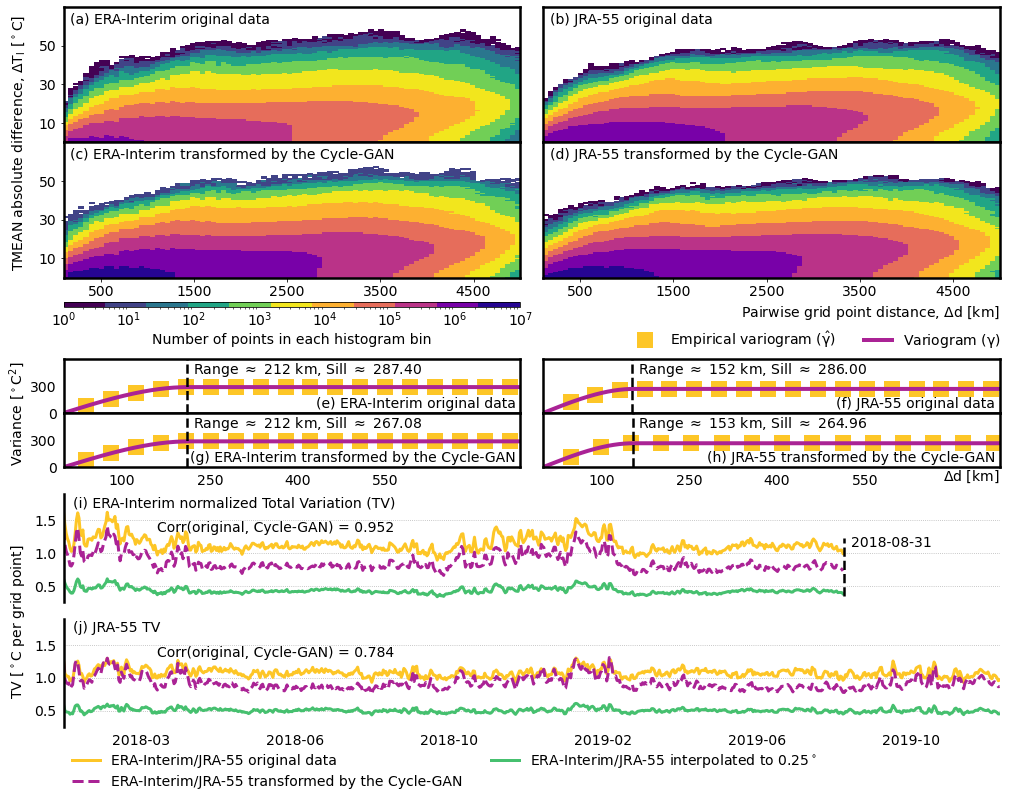

In [82]:
d = 0.05

fig = plt.figure(figsize=(13, 10))
gs = gridspec.GridSpec(9, 2, height_ratios=[1.25, 1.25, 0.75, 0.5, 0.5, 0.25, 1, 0.15, 1], width_ratios=[1, 1])

ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[1, 0])
ax4 = plt.subplot(gs[1, 1])
ax_mid = plt.subplot(gs[2, :])
ax5 = plt.subplot(gs[3, 0])
ax6 = plt.subplot(gs[3, 1])
ax7 = plt.subplot(gs[4, 0])
ax8 = plt.subplot(gs[4, 1])
ax_gap1 = plt.subplot(gs[5, :])
ax9 = plt.subplot(gs[6, :])
ax_gap2 = plt.subplot(gs[7, :])
ax10 = plt.subplot(gs[8, :])

plt.subplots_adjust(0, 0, 1, 1, hspace=0, wspace=0.05)

ax_mid.set_axis_off()
ax_gap1.set_axis_off()
ax_gap2.set_axis_off()

AX1 = [ax1, ax2, ax3, ax4]
AX2 = [ax5, ax6, ax7, ax8]
ptitles = ['(a) ERA-Interim original data',  '(b) JRA-55 original data',
           '(c) ERA-Interim transformed by the Cycle-GAN', '(d) JRA-55 transformed by the Cycle-GAN']
ptitle_locx = [0.015]*4
ptitle_locy = [0.96]*4

vtitles = ['(e) ERA-Interim original data', '(f) JRA-55 original data', 
           '(g) ERA-Interim transformed by the Cycle-GAN', '(h) JRA-55 transformed by the Cycle-GAN']
vtitle_locx = [0.99]*4
vtitle_locy = [0.04]*2 + [0.05]*2

xlabels = ['Pairwise grid point distance, $\mathsf{\Delta d}$ [km]', '$\mathsf{\Delta d}$ [km]']
ylabels = ['TMEAN absolute difference, $\mathsf{\Delta T_l}$ [$\mathsf{^\circ C}$]',
           'Variance [$\mathsf{^\circ C}^2$]',
           'TV [$\mathsf{^\circ C}$ per grid point]']

for i, ax in enumerate(AX1):
    ax = gu.ax_decorate_box(ax)
    ax.set_xlim([100, 5000])
    ax.set_ylim([0, 70])
    ax.set_xticks([500, 1500, 2500, 3500, 4500])
    ax.set_yticks([10, 30, 50])
#     ax.set_xscale('log')
#     ax.set_yscale('log')
    handle_box = ax.text(ptitle_locx[i], ptitle_locy[i], ptitles[i], fontsize=14, ha='left', va='top', transform=ax.transAxes)
    handle_box.set_bbox(dict(facecolor='none', alpha=1, edgecolor='none'))

ax1.tick_params(left=True, labelleft=True)
ax3.tick_params(left=True, labelleft=True, bottom=True, labelbottom=True)
ax4.tick_params(bottom=True, labelbottom=True)

handle_box = ax4.text(1.0, -0.325, xlabels[0], fontsize=14, ha='right', va='bottom', transform=ax4.transAxes)
handle_box.set_bbox(dict(facecolor='none', alpha=1, edgecolor='none'))
handle_box = ax1.text(-0.08, 0, ylabels[0], fontsize=14, rotation=90, ha='right', va='center', transform=ax1.transAxes)
handle_box.set_bbox(dict(facecolor='none', alpha=1, edgecolor='none'))

for i, ax in enumerate(AX2):
    ax = gu.ax_decorate_box(ax)
    ax.set_xlim([0, 780])
    ax.set_ylim([0, 600])
    ax.set_xticks([100, 250, 400, 550])
    ax.set_yticks([0, 300])
    handle_box = ax.text(vtitle_locx[i], vtitle_locy[i], vtitles[i], fontsize=14, ha='right', va='bottom', transform=ax.transAxes)
    handle_box.set_bbox(dict(facecolor='none', alpha=1, edgecolor='none'))

ax5.tick_params(labelleft=True)
ax7.tick_params(labelleft=True, labelbottom=True)
ax8.tick_params(labelbottom=True)

handle_box = ax8.text(1.0, -0.325, xlabels[1], fontsize=14, ha='right', va='bottom', transform=ax8.transAxes)
handle_box.set_bbox(dict(facecolor='none', alpha=1, edgecolor='none'))
handle_box = ax5.text(-0.08, 0, ylabels[1], fontsize=14, rotation=90, ha='right', va='center', transform=ax5.transAxes)
handle_box.set_bbox(dict(facecolor='none', alpha=1, edgecolor='none'))

ax1.pcolormesh(ERA_raw_X, ERA_raw_Y, ERA_raw_H, norm=colors.LogNorm(1e0, 1e7), cmap=vmap)
ax2.pcolormesh(JRA_raw_X, JRA_raw_Y, JRA_raw_H, norm=colors.LogNorm(1e0, 1e7), cmap=vmap)

ax3.pcolormesh(ERA_clean_X, ERA_clean_Y, ERA_clean_H, norm=colors.LogNorm(1e0, 1e7), cmap=vmap)
CS = ax4.pcolormesh(JRA_clean_X, JRA_clean_Y, JRA_clean_H, norm=colors.LogNorm(1e0, 1e7), cmap=vmap)

line1 = ax5.plot(fitx_raw_ERA[30::33], 2*fity_raw_ERA[30::33]+np.random.uniform(low=-d, high=d, size=(30,)), 
         'bs', ms=16, mfc=C2, mec=C1, mew=0, label='Empirical variogram ($\mathsf{\hat{\gamma}}$)')
line2 = ax5.plot(fitx_raw_ERA, 2*fity_raw_ERA, '-k', lw=4.0, color=C1, label='Variogram ($\mathsf{\gamma}$)')

ax6.plot(fitx_raw_JRA[30::27], 2*fity_raw_JRA[30::27]+np.random.uniform(low=-d, high=d, size=(36,)), 'bs', ms=16, mfc=C2, mec=C1, mew=0)
ax6.plot(fitx_raw_JRA, 2*fity_raw_JRA, '-k', lw=4.0, color=C1)

ax7.plot(fitx_clean_ERA[30::33], 2*fity_clean_ERA[30::33]+np.random.uniform(low=-d, high=d, size=(30,)), 'bs', ms=16, mfc=C2, mec=C1, mew=0)
ax7.plot(fitx_clean_ERA, 2*fity_clean_ERA, '-k', lw=4.0, color=C1)

ax8.plot(fitx_clean_JRA[30::33], 2*fity_clean_JRA[30::33]+np.random.uniform(low=-d, high=d, size=(30,)), 'bs', ms=16, mfc=C2, mec=C1, mew=0)
ax8.plot(fitx_clean_JRA, 2*fity_clean_JRA, '-k', lw=4.0, color=C1)

ax5.axvline(x=fitx_raw_ERA[164], color='k', linestyle='--', lw=2.5, ymin=0, ymax=1)
ax7.axvline(x=fitx_clean_ERA[164], color='k', linestyle='--', lw=2.5, ymin=0, ymax=1)
ax5.text(fitx_clean_ERA[164]+10, 480, r'Range $\mathrm{\approx}$ 212 km, Sill $\mathrm{\approx}$ 287.40', fontsize=14, va='center', ha='left')
ax7.text(fitx_clean_ERA[164]+10, 480, r'Range $\mathrm{\approx}$ 212 km, Sill $\mathrm{\approx}$ 267.08', fontsize=14, va='center', ha='left')

ax6.axvline(x=fitx_raw_JRA[97], color='k', linestyle='--', lw=2.5, ymin=0, ymax=1)
ax8.axvline(x=fitx_clean_JRA[98], color='k', linestyle='--', lw=2.5, ymin=0, ymax=1)
ax6.text(fitx_clean_JRA[97]+10, 480, r'Range $\mathrm{\approx}$ 152 km, Sill $\mathrm{\approx}$ 286.00', fontsize=14, va='center', ha='left')
ax8.text(fitx_clean_JRA[97]+10, 480, r'Range $\mathrm{\approx}$ 153 km, Sill $\mathrm{\approx}$ 264.96', fontsize=14, va='center', ha='left')

ax_lg = fig.add_axes([0.615/1.025, 0.51, 0.415, 0.06])
ax_lg.set_axis_off()
LG = ax_lg.legend(handles=[line1[0], line2[0]], bbox_to_anchor=(1, 1), ncol=2, prop={'size':14});
LG.get_frame().set_facecolor('white')
LG.get_frame().set_edgecolor('k')
LG.get_frame().set_linewidth(0)

ax_base = fig.add_axes([0, 0.565, 0.5/1.025, 0.025]) #1/4+0.008, 0.0475
[j.set_linewidth(0) for j in ax_base.spines.values()]
ax_base.tick_params(axis='both', left=False, top=False, right=False, bottom=False, \
                    labelleft=False, labeltop=False, labelright=False, labelbottom=False)
cax = inset_axes(ax_base, width='100%', height='25%', borderpad=0, loc=9)
CBar = plt.colorbar(CS, orientation='horizontal', cax=cax)
CBar.set_label('Number of points in each histogram bin', fontsize=14)
CBar.ax.tick_params(axis='x', labelsize=14, direction='in', length=0)
CBar.ax.set_title('', fontsize=14, x=0.02, ha='left')
#CBar.outline.set_linewidth(2.5)
# Save figure
# ---------------------------------------------
titles = ['(i) ERA-Interim normalized Total Variation (TV)', '(j) JRA-55 TV']
for i, ax in enumerate([ax9, ax10]):
    ax.grid(linestyle=':'); ax.xaxis.grid(False)
    ax.spines["left"].set_visible(True)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.xaxis.set_tick_params(labelsize=14)
    ax.yaxis.set_tick_params(labelsize=14)
    [j.set_linewidth(2.5) for j in ax.spines.values()]
    ax.tick_params(axis="both", which="both", bottom=False, top=False, labelbottom=False, left=False, right=False, labelleft=True)
    ax.set_xlim([0, fake_x[-1]])
    ax.set_ylim([0.25, 1.9])
    #ax.set_yticks([0.7, 1.4, 2.1, 2.8])
    ax.set_title(titles[i], fontsize=14, ha='left', va='bottom', x=0.01, y=0.8)

handle_box = ax9.text(-0.039, -0.18, ylabels[2], fontsize=14, rotation=90, ha='right', va='center', transform=ax9.transAxes)
handle_box.set_bbox(dict(facecolor='none', alpha=1, edgecolor='none'))
    
ax9.text(0.1, 0.75, 'Corr(original, Cycle-GAN) = {}'.format(rtv_era), ha='left', va='top', fontsize=14, transform=ax9.transAxes)    
ax10.text(0.1, 0.75, 'Corr(original, Cycle-GAN) = {}'.format(rtv_jra), ha='left', va='top', fontsize=14, transform=ax10.transAxes)

ax10.tick_params(labelbottom=True)
ticks = [60, 180, 300, 420, 540, 660]
ax10.set_xticks(ticks)
labels = []
for tick in ticks:
    labels.append(datetime.strftime(pred_list_jra[tick], '%Y-%m'))
ax10.set_xticklabels(labels)

ax9.plot(fake_x, ERA_raw_fill, lw=3, color=C2)
ax9.plot(fake_x, ERA_clean_fill, lw=3, ls='--', color=C1)
ax9.plot(fake_x, ERA_025_fill, lw=3, color=C3)

ax9.axvline(x=N_pred_era, ymin=0.06, ymax=0.6, lw=2.5, ls='--', color='k')
ax9.text(N_pred_era+5, 1.05, '2018-08-31', fontsize=14, ha='left', va='bottom')

lines = []
lines += ax10.plot(fake_x, JRA_raw_TV, lw=3, color=C2, 
         label='ERA-Interim/JRA-55 original data')
lines += ax10.plot(fake_x, JRA_clean_TV, lw=3, ls='--', color=C1, 
                      label='ERA-Interim/JRA-55 transformed by the Cycle-GAN')
lines += ax10.plot(fake_x, JRA_025_TV, lw=3, color=C3, 
                      label='ERA-Interim/JRA-55 interpolated to 0.25$\mathsf{^\circ}$')

ax_lg = fig.add_axes([0, -0.09, 0.818, 0.0725])
ax_lg.set_axis_off()
LG = ax_lg.legend(handles=lines, bbox_to_anchor=(1, 1), ncol=2, prop={'size':14});
LG.get_frame().set_facecolor('white')
LG.get_frame().set_edgecolor('k')
LG.get_frame().set_linewidth(0)

# Save figure
fig.savefig(fig_dir+'CGAN_perturb.png', format='png', **fig_keys)

In [61]:
2*fity_raw_ERA[-1]

287.39948349770077

In [45]:
fity_raw_JRA[-1]

133.53568980214698

In [46]:
fity_clean_ERA[-1]

142.99711877715424

In [47]:
fity_clean_JRA[-1]

132.4779351500151